# Project 04: Phân lớp văn bản với kĩ thuật bình phương tối tiểu
#### Họ tên : Kiều Vũ Minh Đức
#### MSSV : 18127080
#### Lớp 18CLC4

In [76]:
# DON'T CHANGE this part: import libraries
import numpy as np
import scipy
import json
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import re
import itertools

In [77]:
# DON'T CHANGE this part: read data path
train_set_path, valid_set_path, random_number = input().split()

train.json valid.json 69


In [78]:
# TODO:
# 1. preprocess: converting text to lowercase, coverting number, tokenization, removing stopword, stemming
# 2. embedding: hitogram matrix
# 3. classifier using linear regression
# 4. accuracy (for metric)

#### Ví dụ cho phần báo cáo, nên báo cáo cho từng phần code để rõ ràng

Báo cáo phần tiền xử lý: dùng xyz để tách từ, ...

... Đối với những từ out-of-vocab (xuất hiện trong tập train nhưng không có ở tập valid), xử lý bằng cách ... 

Trước khi có thể chạy được chương trình, người dùng cần phải tải về bộ thư viện `nltk`, sau đó download gói `punkt` và `stopwords`

### Phân tích thuật toán

In [79]:
# Ví dụ cho phần code hàm tiền xử lý

stop_words = set(stopwords.words('english'))
def preprocess(text):
    # converting text to lowercase
    text = text.lower()
    text = re.sub(" \d+", " num ", text)
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stem_sentence = []
    ps = PorterStemmer()
    for w in filtered_sentence:
        stem_sentence.append(ps.stem(w))
    return stem_sentence

Hàm trên sử dụng các bộ thư viện cơ bản trong `nltk` và `regex` để có thể tiền xử lý các dữ liệu trong một đoạn text
+ Hàm `lower()` dùng để chuyển các ký tự in sang ký tự thường
+ Hàm `re.sub()` được dùng để thay thế các ký tự có một format định sẵn về một chuỗi khác, như ở trên ta có thể chuyển các ký tự có format digit về 'num'
+ Hàm `word_tokenize()` của bộ thư viện `nltk` dùng để tách chữ
+ Ngoài ra `nltk` còn cung cấp một bộ từ ngữ được xem là **stopwords** theo ngôn ngữ tiếng anh, dùng để có thể filter các từ này ra khỏi câu một cách dễ dàng. Các **stopwords** là các từ không mang ý nghĩa nếu đứng riêng lẻ
+ Cuối cùng là class `PorterStemmer()`, dùng để stem (chuẩn hóa các dạng loại từ)
Các stopwords được sử dụng như một global variable

In [80]:
word_set = set(['unk'])
def word_set_create(word_vector):
    word_set.update(word_vector)

Việc dùng một set để làm một cơ sở để đếm các từ xuất hiện trong bộ data dùng để train tiện hơn, do set không bị lặp mỗi khi upgrade thêm phần tử mới vào. Nên em sử dụng một set để làm một data structure lưu lại toàn bộ các từ đã xuất hiện trong train data.
Ngoài ra, cần thêm vào set một phần từ 'unk' để có thể xử lý cho các ký tự không xuất hiện trong bộ train nhưng lại xuất hiện trong bộ test

In [81]:
def label_create(scores):
    multi_label = np.zeros(5)
    multi_label[int(scores[0] - 1)] += 1
    for index in range(1, len(scores)):
        multi_label_temp = np.zeros(5)
        multi_label_temp[int(scores[index] - 1)] += 1
        multi_label = np.vstack((multi_label, multi_label_temp))
    return multi_label

Hàm này được dùng để chuẩn hóa các dạng label về dạng vector thích hợp cho multi label classification, ví dụ như data point có $y_i = 5$, thì sau khi qua hàm này, kết quả trả về là $y_i = [0,0,0,0,1]$. Ta làm như vậy với toàn bộ dataset trong tập train, và chồng các vector $y_i$ lên theo theo chiều axis = 0. Cuối cùng trả về ma trận $(mx5)$ với m là số lượng data point.

In [82]:
def word_count(text_vector):
    counter = dict.fromkeys(word_set, 0)
    sum = 0
    for w in text_vector:
        if w in word_set:
            counter[w]+=1
            sum+=1
    histogram = []
    for each in counter.values():
        histogram.append(each/sum)
    return histogram

Hàm này đảm nhiệm việc đếm số lần xuất hiện của một từ $a_i$ trong sentence (cụ thể ở đây là một sentence đã được tokenize tạo thành một vector). Sau khi đếm xong, hàm sẽ tính tần số xuất hiện của từ đó trong câu, bằng cách $\frac{count(a_i)}{sum(sentence)}$

In [83]:
def word_embedding(train_data,valid_data,number):
    text1 = []
    for each in train_data:
        text1.append(preprocess(each['reviewText']))
    histogram_train = []
    for each in text1:
        histogram_train.append(word_count(each))
    histogram_train = np.asarray(histogram_train)
    histogram_train = histogram_train.reshape((len(text1),len(word_set)))

    text2 = []
    for each in valid_data:
        temp = preprocess(each['reviewText'])
        for index,w in enumerate(temp):
            if w not in word_set:
                temp[index] = 'unk'
        text2.append(temp)
    histogram_valid = []
    for each in text2:
        histogram_valid.append(word_count(each))
    histogram_valid = np.asarray(histogram_valid)
    histogram_valid = histogram_valid.reshape((len(text2), len(word_set)))
    return histogram_train,histogram_valid,text2[int(number)]

Hàm này được dùng để xây dụng các vector từ các đoạn text, nói cách khác là bỏ đoạn text vào phần hàm `preprocessing()` bên trên để xử lý, sau đó tính toán histogram bằng hàm `word_count()`. Ngoài ra hàm này có công dụng xử lý cả phần data trong bộ valid, thay thế các ký tự không nằm trong `word_set` thành `unk`, và cuối cùng là truy xuất sentence thứ $i$ sau khi đã được xử lý xong.

In [84]:
def read_file(train_set_path,valid_set_path):
    train_file = open(train_set_path, 'r')
    train_file = json.load(train_file)
    train_scores = []
    for each in train_file:
        word_set_create(preprocess(each['reviewText']))
        train_scores.append(int(each['overall']))
    train_label = label_create(train_scores)

    valid_file = open(valid_set_path, 'r')
    valid_file = json.load(valid_file)
    valid_scores = []
    for each in valid_file:
        valid_scores.append(int(each['overall']))
    valid_label = np.asarray(valid_scores).reshape((len(valid_file),))
    h_train,h_valid, sentence = word_embedding(train_file,valid_file,random_number)
    print(sentence)
    return h_train, train_label, h_valid, valid_label

Việc xử lý các file, tách các dữ liệu trong dictionary ra thành các thành phần (do file json khi được đọc vào sẽ được lưu dưới dạng một dictionary). Nhìn chung ta cần phần **overall** để làm label cho phần **reviewText**.

In [85]:
def fit_weight(matrix,score):
    x0 = np.ones((matrix.shape[0],1))
    matrix = np.hstack((x0,matrix))
    w = np.linalg.pinv(matrix)@score
    return w

Sau giai đoạn xử lý file và chuyển các vector từ về dạng số, áp dụng phương pháp bình phương tối tiểu, tìm nghiệm $w$ làm $minimize(|Aw - b|^2)$ bằng phương trình $w = A^\dagger b$

In [86]:
def predict(matrix,w,real_label):
    x0 = np.ones((matrix.shape[0],1))
    matrix = np.hstack((x0,matrix))
    label = matrix@w
    prob = scipy.special.softmax(label,axis = 1)
    label = (np.argmax(prob,axis = 1) + 1)
    error = np.count_nonzero(label - real_label)
    return 1 - (error/matrix.shape[0])


Sau cùng, sử dụng $w$ bên trên để dự đoán cho dữ liệu trong tập valid/test để trả ra label, sử dụng label thật của dữ liệu để tính toán **accuracy** cho mô hình

In [87]:
if __name__ == '__main__':
    h_train, train_label,h_valid, valid_label = read_file(train_set_path,valid_set_path)
    w = fit_weight(h_train, train_label)
    print('M2 - ',predict(h_valid,w,valid_label))

    

['must', 'tool', 'needl', 'felt', '!', 'great', 'qualiti', 'work', 'wonder', '!', 'real', 'time', 'saver', '!']
M2 -  0.518


### Thảo luận

Mô hình cho ra kết quả không được tốt lắm, việc xử lý dữ liệu tương đối ổn. Tuy nhiên sau một số công việc phân tích đơn giản, chúng ta có thể thấy sự bất cân đối trong tập train của bộ dữ liệu, điều này dẫn đến việc mô hình không được tốt.
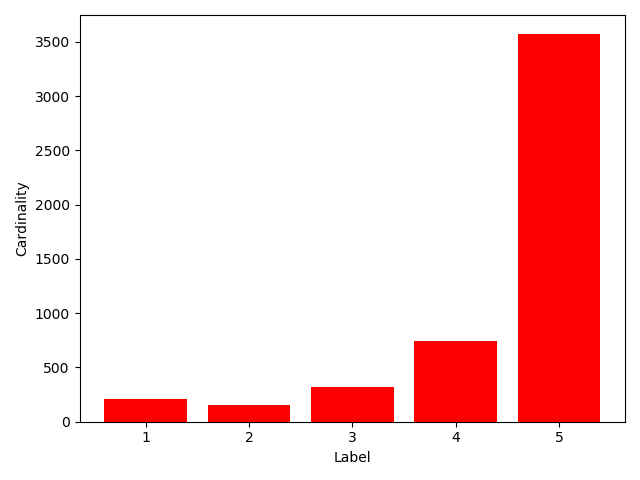

### Tham khảo
[logistic regression](https://machinelearningcoban.com/2017/01/27/logisticregression/)
[NLTK](https://www.nltk.org/)
[Regex](https://topdev.vn/blog/regex-la-gi/)
[Replace Regex](https://stackoverflow.com/questions/817122/delete-digits-in-python-regex)